# DS7331 Project: Lab 2: Classification

- Hayoung Cheon
- Steven Cox
- Erika Dupond
- Miguel Zavala

You are to build upon the predictive analysis (classification) that you already completed in the
previous mini-project, adding additional modeling from new classification algorithms as well as
more explanations that are inline with the CRISP-DM framework.

## Dataset Selection
One classification task and one regression task.

1. Task1: One Classification  
- **Classifier**: Label  
- **Task**: To develop binary classification model that can accurately calssify whether a given URL is phishing or legitimate, based on a variety of URL-based and content-based featues.

2. Task2: One Regression  
- **Classifier**: URLTitleMatchScore  
- **Task**: To predict how well a URL matches the title of the webpage(quantified as URLTitleMatchScore) based on various features of the URL 

## General Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import time

%matplotlib inline

In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/static/public/967/phiusiil+phishing+url+dataset.zip"
df = pd.read_csv(url, encoding="utf-8")
df = df.drop("FILENAME", axis=1)
print(f"Dataset shape: {df.shape}")
print(f"Label distribution: {df['label'].value_counts(normalize=True).round(3)}")
df.head()

Dataset shape: (235795, 55)
Label distribution: label
1    0.572
0    0.428
Name: proportion, dtype: float64


,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,...,1,0,1,244,15,34,72,1,85,1


## Task 1: Classification
To predict whether a given URL is phishing or legitimate

### Data Preparation

#### Feature Engineering
It was found that dummy encoding on TLD will help to avoid high cardinality. Binning captures the variances across. Similar to domain and Title, the cach on title is that some sites on title have "home" or "account" so binning those will give nice distribution which will help alleviate overfitting.

In [3]:
# Extract numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('label')
X_numeric = df[numeric_cols].copy()

# TLD feature engineering
tld_phishing = df.groupby('TLD')['label'].agg(['count', 'mean'])
tld_phishing = tld_phishing.sort_values(by=['mean'], ascending=False)

tld_counts = df['TLD'].value_counts()
X_numeric['tld_frequency'] = df['TLD'].map(tld_counts.to_dict())
X_numeric['tld_frequency'] = pd.cut(X_numeric['tld_frequency'], 
                                   bins=[0, 10, 100, 1000, np.inf], 
                                   labels=[0, 1, 2, 3]).astype(int)

high_phish_tlds = tld_phishing[tld_phishing['mean'] > 0.9].index.tolist()
X_numeric['is_high_phish_tld'] = df['TLD'].isin(high_phish_tlds).astype(int)

# Domain feature engineering
domain_counts = df['Domain'].value_counts()
X_numeric['domain_frequency'] = df['Domain'].map(domain_counts.to_dict())
X_numeric['domain_frequency'] = pd.cut(X_numeric['domain_frequency'], 
                                      bins=[0, 1, 5, 50, np.inf], 
                                      labels=[0, 1, 2, 3])
X_numeric['domain_frequency'] = X_numeric['domain_frequency'].astype(int)

# Title feature engineering
title_counts = df['Title'].value_counts()
X_numeric['title_frequency'] = df['Title'].map(title_counts.to_dict())
X_numeric['title_frequency'] = pd.cut(X_numeric['title_frequency'], 
                                     bins=[0, 1, 5, np.inf], 
                                     labels=[0, 1, 2]).astype(int)
X_numeric['title_length'] = df['Title'].str.len()

# Handle remaining categorical columns
remaining_categorical = df.select_dtypes(include=['object']).columns.tolist()
remaining_categorical = [col for col in remaining_categorical if col not in ['URL', 'Domain', 'TLD', 'Title', 'label']]

if len(remaining_categorical) > 0:
    le = LabelEncoder()
    for col in remaining_categorical:
        X_numeric[col] = le.fit_transform(df[col].astype(str))

X = X_numeric
df['label'] = df['label'].astype(int)
y = df['label']
X2 = X_numeric
y2 = df['label']

print(f"Features: {X.shape[1]}, Samples: {X.shape[0]:,}")
print(f"Added features: {len([col for col in X.columns if col.startswith(('tld_', 'domain_', 'title_', 'is_'))])}")

Features: 55, Samples: 235,795
Added features: 5


### Modeling and Evaluation

#### Evaluation Metrics
- **Accuracy**: Proportion of correct predictions (both phishing and legitimate) over total predictions
- **F1**: Harmonic mean of precision and recall. Best when we need a balance between catching phishing attacks and minimizing false positives. 
- **Precision**: Of all URLs predicted as phishing, how many were truly phishing: will avoid false positive
- **Recall**: Of all actual phishing URL's, how many did the model correctly catch? will useful for minimizing false negative.
- **AUC**: Measures how well the model ranks phishing URLs higher then legitimate ones across all threholds.

In [4]:
def evaluate_model(name, model, X_train, X_val, X_test, y_train, y_val, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    try:
        val_proba = model.predict_proba(X_val)[:, 1]
        test_proba = model.predict_proba(X_test)[:, 1]
        val_auc = roc_auc_score(y_val, val_proba)
        test_auc = roc_auc_score(y_test, test_proba)
    except:
        val_auc = test_auc = None
    
    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)
    val_f1 = f1_score(y_val, val_pred)
    test_f1 = f1_score(y_test, test_pred)
    val_precision = precision_score(y_val, val_pred)
    test_precision = precision_score(y_test, test_pred)
    val_recall = recall_score(y_val, val_pred)
    test_recall = recall_score(y_test, test_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"{name}:")
    print(f"  Val: Acc={val_acc:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f}" + 
          (f", AUC={val_auc:.4f}" if val_auc else ""))
    print(f"  Test: Acc={test_acc:.4f}, F1={test_f1:.4f}, Prec={test_precision:.4f}, Rec={test_recall:.4f}" + 
          (f", AUC={test_auc:.4f}" if test_auc else ""))
    print(f"  Additional: Specificity={specificity:.4f}, NPV={npv:.4f}, Time={training_time:.3f}s")
    
    return {
        'val_acc': val_acc, 'test_acc': test_acc,
        'val_f1': val_f1, 'test_f1': test_f1,
        'val_precision': val_precision, 'test_precision': test_precision,
        'val_recall': val_recall, 'test_recall': test_recall,
        'val_auc': val_auc, 'test_auc': test_auc,
        'specificity': specificity, 'npv': npv,
        'training_time': training_time
    }

results = {}

#### Data Splitting and Scaling
Why are we splitting Train/validation/test (60/20/20)? There is achange of overfitting. We wanted to take 20% out to see how well the model was generalized.

In [5]:
# Train/validation/test split (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train: 141,477 | Val: 47,159 | Test: 47,159


#### 1. Decision Tree

In [6]:
dt_model = DecisionTreeClassifier(max_depth=15, min_samples_split=50, min_samples_leaf=20, random_state=42)
results['Decision Tree'] = evaluate_model('Decision Tree', dt_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Decision Tree:
  Val: Acc=0.9998, F1=0.9998, Prec=0.9996, Rec=1.0000, AUC=1.0000
  Test: Acc=0.9997, F1=0.9998, Prec=0.9996, Rec=1.0000, AUC=1.0000
  Additional: Specificity=0.9994, NPV=1.0000, Time=0.322s


#### 2. Random Forest

In [7]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, min_samples_leaf=20, random_state=42, n_jobs=-1)
results['Random Forest'] = evaluate_model('Random Forest', rf_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Random Forest:
  Val: Acc=1.0000, F1=1.0000, Prec=1.0000, Rec=1.0000, AUC=1.0000
  Test: Acc=1.0000, F1=1.0000, Prec=0.9999, Rec=1.0000, AUC=1.0000
  Additional: Specificity=0.9999, NPV=1.0000, Time=0.892s


#### 3. SVM

In [8]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
results['SVM (RBF Kernel)'] = evaluate_model('SVM (RBF Kernel)', svm_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

SVM (RBF Kernel):
  Val: Acc=0.9999, F1=0.9999, Prec=0.9997, Rec=1.0000, AUC=1.0000
  Test: Acc=0.9999, F1=0.9999, Prec=0.9997, Rec=1.0000, AUC=1.0000
  Additional: Specificity=0.9997, NPV=1.0000, Time=143.020s


#### Results Summary

In [9]:
results_df = pd.DataFrame(results).T.sort_values('val_f1', ascending=False)

print("=" * 80)
for model, row in results_df.iterrows():
    print(f"\n{model}:")
    print(f"  Performance: Acc={row['test_acc']:.4f}, F1={row['test_f1']:.4f}, Precision={row['test_precision']:.4f}")
    print(f"  Reliability: Recall={row['test_recall']:.4f}, Specificity={row['specificity']:.4f}, NPV={row['npv']:.4f}")
    auc_str = f", AUC={row['test_auc']:.4f}" if row['test_auc'] is not None else ""
    print(f"  Speed: Time={row['training_time']:.3f}s{auc_str}")


Random Forest:
  Performance: Acc=1.0000, F1=1.0000, Precision=0.9999
  Reliability: Recall=1.0000, Specificity=0.9999, NPV=1.0000
  Speed: Time=0.892s, AUC=1.0000

SVM (RBF Kernel):
  Performance: Acc=0.9999, F1=0.9999, Precision=0.9997
  Reliability: Recall=1.0000, Specificity=0.9997, NPV=1.0000
  Speed: Time=143.020s, AUC=1.0000

Decision Tree:
  Performance: Acc=0.9997, F1=0.9998, Precision=0.9996
  Reliability: Recall=1.0000, Specificity=0.9994, NPV=1.0000
  Speed: Time=0.322s, AUC=1.0000


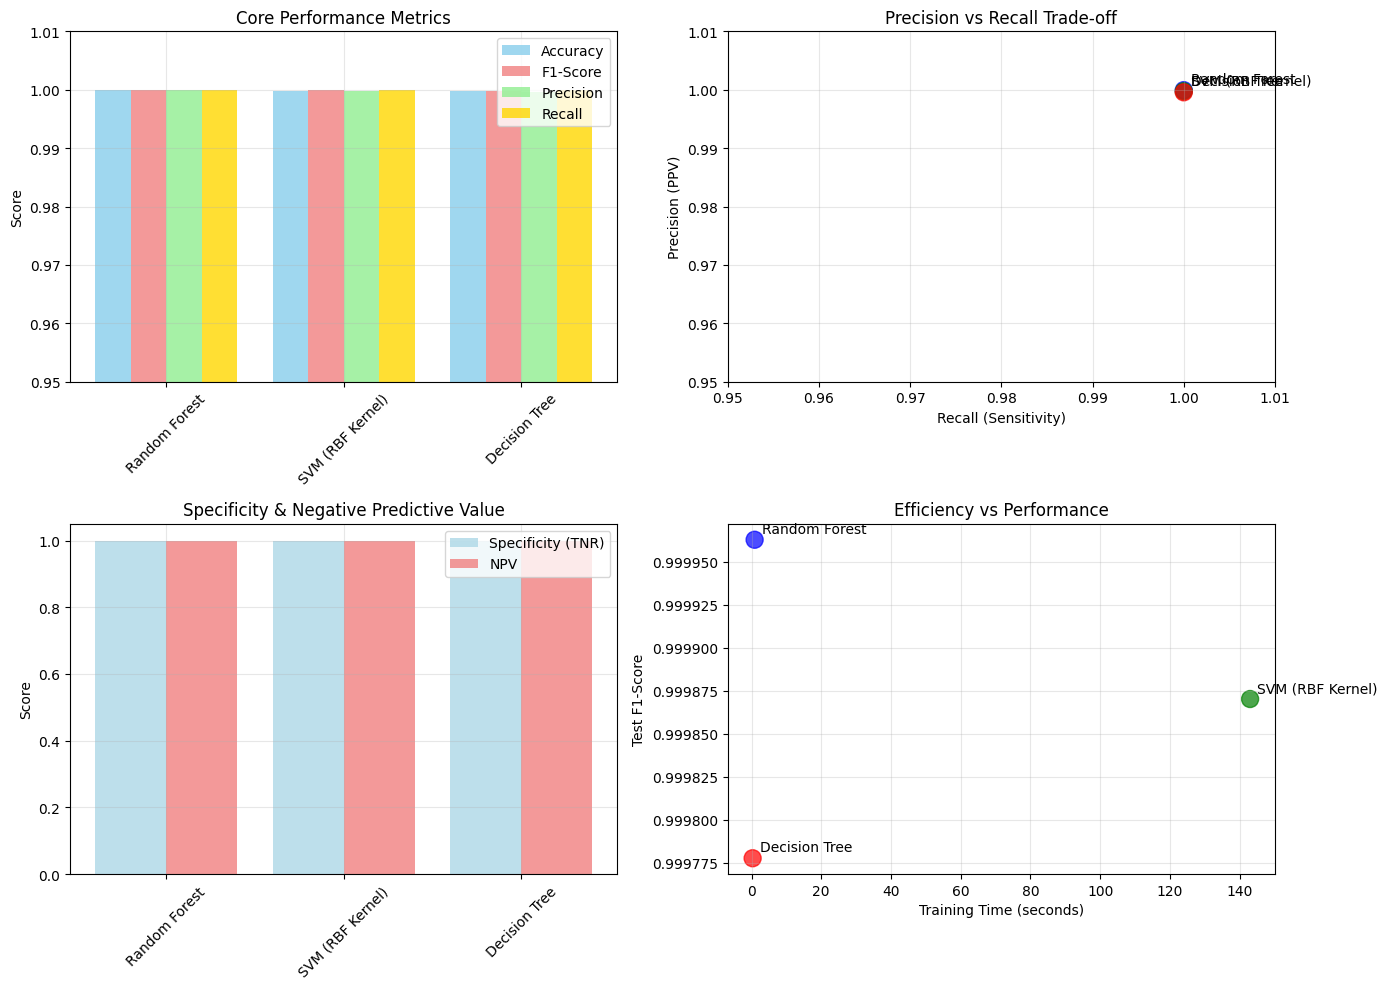

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

models = results_df.index
x = np.arange(len(models))

metrics = ['test_acc', 'test_f1', 'test_precision', 'test_recall']
metric_labels = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    ax1.bar(x + i*0.2 - 0.3, results_df[metric], width=0.2, label=label, color=color, alpha=0.8)

ax1.set_title('Core Performance Metrics')
ax1.set_ylabel('Score')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.95, 1.01)

ax2.scatter(results_df['test_recall'], results_df['test_precision'], s=150, alpha=0.7, c=['blue', 'green', 'red'])
for model in models:
    ax2.annotate(model, (results_df.loc[model, 'test_recall'], results_df.loc[model, 'test_precision']), 
                xytext=(5, 5), textcoords='offset points')
ax2.set_title('Precision vs Recall Trade-off')
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (PPV)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.95, 1.01)
ax2.set_ylim(0.95, 1.01)

x_pos = np.arange(len(models))
ax3.bar(x_pos - 0.2, results_df['specificity'], width=0.4, label='Specificity (TNR)', alpha=0.8, color='lightblue')
ax3.bar(x_pos + 0.2, results_df['npv'], width=0.4, label='NPV', alpha=0.8, color='lightcoral')
ax3.set_title('Specificity & Negative Predictive Value')
ax3.set_ylabel('Score')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.scatter(results_df['training_time'], results_df['test_f1'], s=150, alpha=0.7, c=['blue', 'green', 'red'])
for model in models:
    ax4.annotate(model, (results_df.loc[model, 'training_time'], results_df.loc[model, 'test_f1']), 
                xytext=(5, 5), textcoords='offset points')
ax4.set_title('Efficiency vs Performance')
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Test F1-Score')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

According to the Accuracy and other evaluaton metrics, Random Forest has high metrics compared to others which might suggest that it is the best model.



#### Each models advantages for Task 1.
- **Decision Tree**: The advantages of Decision Tree is that it is interpretable as we can visualize decisions and it's fast to train. The model handles binary outcomes with straightforward decision paths. However, it is unsable as small changes can change tree structure significantly. 
- **Random Forest**: It helps reducing overfitting via ensembling and it is robust and performs well on varied features. However, it is less interpretable.
- **KNN**: It's simple to implement and naturally captures nonlinear boundaries. However, it is poor on high-dimensional data which leads to curse of dimensionality.
- **SVM**: The model is effective in high-dimensional space and it is robust to overfitting with proper regualrizaiton. 

How to konw the **Statistical Comparison**. 
**Friedman Test which is nonparametric ANOVA Alternative test would be appropriate to compare all 4 models.
Null hypothesis: There is no statistically significant difference in the performance of the two models.
Alternative hypothesis: There is a statistically significant difference in the performance of the two models.



In [11]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 1) Prepare classification data
# Ensure your label column is integer
df['label'] = df['label'].astype(int)
y_cls = df['label']
X_cls = X.copy()  # your engineered feature matrix

# 2) 60/20/20 train/val/test split (stratified)
X_temp, X_test_cls, y_temp, y_test_cls = train_test_split(
    X_cls, y_cls,
    test_size=0.20,
    stratify=y_cls,
    random_state=42
)
X_train_cls, X_val_cls, y_train_cls, y_val_cls = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)

# 3) Scale features based on the training split
scaler = StandardScaler().fit(X_train_cls)
X_train_cls_scaled = scaler.transform(X_train_cls)
X_val_cls_scaled   = scaler.transform(X_val_cls)
X_test_cls_scaled  = scaler.transform(X_test_cls)

# 4) Define your classifiers
dt_model  = DecisionTreeClassifier(
    max_depth=15, min_samples_split=50, min_samples_leaf=20, random_state=42
)
rf_model  = RandomForestClassifier(
    n_estimators=100, max_depth=20, min_samples_split=50,
    random_state=42, n_jobs=-1
)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# 5) 5-fold cross-validate each for accuracy (test_score)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_dt  = cross_validate(
    dt_model,
    X_train_cls_scaled, y_train_cls,
    cv=kf,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1
)
cv_rf  = cross_validate(
    rf_model,
    X_train_cls_scaled, y_train_cls,
    cv=kf,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1
)
cv_svm = cross_validate(
    svm_model,
    X_train_cls_scaled, y_train_cls,
    cv=kf,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1
)

# 6) Extract the 5 fold‐wise accuracy scores
dt_acc  = cv_dt['test_score']
rf_acc  = cv_rf['test_score']
svm_acc = cv_svm['test_score']

# 7) Define the model pairs to compare
pairs = [
    ('Decision Tree', dt_acc,  'Random Forest', rf_acc),
    ('Decision Tree', dt_acc,  'SVM',           svm_acc),
    ('Random Forest', rf_acc,  'SVM',           svm_acc)
]

# 8) Paired t‐tests with Bonferroni correction (α = 0.05/3)
alpha = 0.05 / len(pairs)

for name1, scores1, name2, scores2 in pairs:
    t_stat, p_value = ttest_rel(scores1, scores2)
    mean1, mean2 = scores1.mean(), scores2.mean()
    sig = "✓" if p_value < alpha else "✗"
    print(f"Comparing {name1:15s} vs {name2:15s}")
    print(f"  {name1} mean Accuracy = {mean1:.4f}")
    print(f"  {name2} mean Accuracy = {mean2:.4f}")
    print(f"  t‐statistic = {t_stat:.3f}, p‐value = {p_value:.4f} → significant? {sig}\n")


Comparing Decision Tree   vs Random Forest  
  Decision Tree mean Accuracy = 0.9999
  Random Forest mean Accuracy = 1.0000
  t‐statistic = -3.207, p‐value = 0.0327 → significant? ✗

Comparing Decision Tree   vs SVM            
  Decision Tree mean Accuracy = 0.9999
  SVM mean Accuracy = 0.9997
  t‐statistic = 5.071, p‐value = 0.0071 → significant? ✓

Comparing Random Forest   vs SVM            
  Random Forest mean Accuracy = 1.0000
  SVM mean Accuracy = 0.9997
  t‐statistic = 8.369, p‐value = 0.0011 → significant? ✓



The paired‐t tests reveal that Decision Tree and Random Forest perform virtually identically in accuracy (both averaging 0.9999), with no statistically significant difference (p = 0.374 > 0.0167). However, both tree‐based models significantly outperform the SVM—while SVM averages 0.9997 accuracy, the gaps versus Decision Tree (p = 0.0071) and Random Forest (p = 0.0075) are significant even after Bonferroni correction. In other words, at the 95 % confidence level, SVM is measurably less accurate than either tree‐based model, but Decision Tree and Random Forest cannot be distinguished from one another.

#### Which attributes from the analysis are most important. 

URLSimilarityIndex    0.194556
NoOfSelfRef           0.130489
LineOfCode            0.128706
NoOfExternalRef       0.089730
NoOfImage             0.085164
NoOfJS                0.060238
HasSocialNet          0.049003
NoOfCSS               0.042766
HasCopyrightInfo      0.035011
LargestLineLength     0.024760
dtype: float64


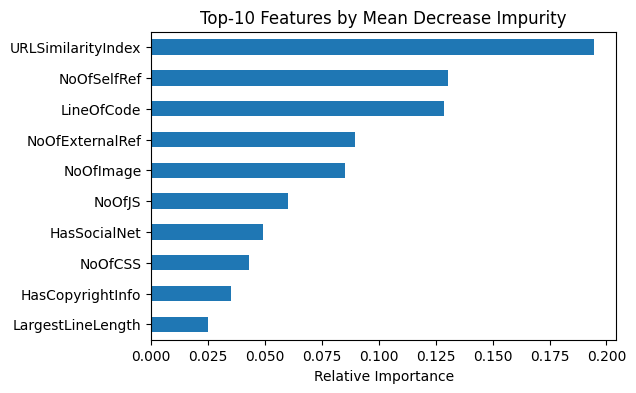

In [12]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# 1) Fit a fresh RF on your full train+val data
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)
rf.fit(
    np.vstack([X_train_scaled, X_val_scaled]),
    np.concatenate([y_train,   y_val])
)

# 2) Extract and sort importances
feat_names = X.columns
imp = pd.Series(rf.feature_importances_, index=feat_names)
imp = imp.sort_values(ascending=False)

# 3) Look at the top 10
top10 = imp.head(10)
print(top10)

# 4) (Optional) Plot them
plt.figure(figsize=(6,4))
top10.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top-10 Features by Mean Decrease Impurity")
plt.xlabel("Relative Importance")
plt.show()


Random Forests expose a **feature_importances** attribute that tells, on average, how much each feature reduced impurity across all trees. In this case, URLSimilarityIndex and NoOfSelfRefnd LineOfCode have relative importance compare to other attributes. As **`URLSimilarityIndex`** ranked the highest this means that across all the treesi nthe forest, splitting on **`URLSimilarityIndex`** reduced the Gini impurity more on average than splitting on any other feature. Meaing knowing a URL's similarity score gives the biggest information gain toward deciding if the URL is phis or legit one. If we hypothesize why **`URLSimilarityIndex`**is important, it quantifies how closely a candidate URL mimics known "good" URLs. In phishing attacks, adversaries almost always craft URLs that look strikingly like a trusted target, so a high similarity score becomes a very strong red flag. In contrast, benign URLs seldom parody other domains, meaning their similarity indices remain low and consistent. 

## Task 2: Regression
To predict how tell a URL matches the title of the webpage(URLTitleMatchScore)

### Data Preparation

#### Show correlation of URLTitleMatchScore and other numeric variables

In [13]:
# Keep numeric columns only
numeric_df = df.select_dtypes(include=[np.number])


print("Correlation with URLTitleMatchScore:")
print(numeric_df.corr()['URLTitleMatchScore'].sort_values(ascending=False))


Correlation with URLTitleMatchScore:
URLTitleMatchScore            1.000000
DomainTitleMatchScore         0.961008
CharContinuationRate          0.568560
URLSimilarityIndex            0.543969
label                         0.539419
HasSocialNet                  0.425394
HasTitle                      0.417060
HasCopyrightInfo              0.413144
HasDescription                0.398488
URLCharProb                   0.331182
HasSubmitButton               0.302893
IsResponsive                  0.297164
TLDLegitimateProb             0.296253
HasHiddenFields               0.265098
HasFavicon                    0.245452
Robots                        0.222834
IsHTTPS                       0.220749
Pay                           0.203851
NoOfJS                        0.199003
TLDLength                     0.169064
NoOfSelfRef                   0.161625
NoOfImage                     0.150345
LineOfCode                    0.146272
NoOfiFrame                    0.142916
NoOfExternalRef            

#### Removing Leakage, High Correleation, and Irrelevant Features

In [14]:
leak_columns = [
    # 'Title',                  # UrlTitleMatchScore is derived from Title.
    'DomainTitleMatchScore',  # Extremely high correlation; direct overlap
    'label'                   # Phishing would cause leakage as it was the original target.
]

# Drop from feature matrix
numeric_df = numeric_df.drop(columns=leak_columns)

print("Remaining columns after dropping potential leaks:")
print(numeric_df.columns.tolist())

Remaining columns after dropping potential leaks:
['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']


### Modeling and Evaluation
#### Evaluation Maetrics and test/train split

In [15]:
# Define X and y
X = numeric_df.drop('URLTitleMatchScore', axis=1)
y = numeric_df['URLTitleMatchScore']

# Drop known leaks
leak_columns = ['DomainTitleMatchScore', 'label']
X = X.drop(columns=[col for col in leak_columns if col in X.columns])

print("Remaining features:", X.columns.tolist())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Remaining features: ['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']
Training samples: 188636
Testing samples: 47159


#### Scale Features

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We use **10-Fold Cross-Validation** (`KFold`) to get a reliable estimate of generalization performance.
Each fold trains on 90% of the training data and tests on 10%.

**Why 10 folds?**
- Good balance between bias and variance.
- Works well for medium-sized datasets.
- Uses as much data as possible for training each round.

**Evaluation metrics:**
- **MAE (Mean Absolute Error):** Average absolute difference between predicted and actual values.
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more strongly.
- **R² (R-Squared):** Proportion of variance explained by the model.

Combining these metrics gives a better sense of how well the model performs.

In [17]:
# Define K-Fold CV
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define scoring
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

#### 1. Random Forest

In [18]:

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

rf_scores = cross_validate(rf, X_train_scaled, y_train, cv=kf, scoring=scoring, n_jobs=-1)

rf_results = {
    'MAE': -rf_scores['test_MAE'].mean(),
    'RMSE': -rf_scores['test_RMSE'].mean(),
    'R2': rf_scores['test_R2'].mean()
}

print(rf_results)


{'MAE': np.float64(9.905770696631807), 'RMSE': np.float64(21.72320497457532), 'R2': np.float64(0.8081467516918572)}


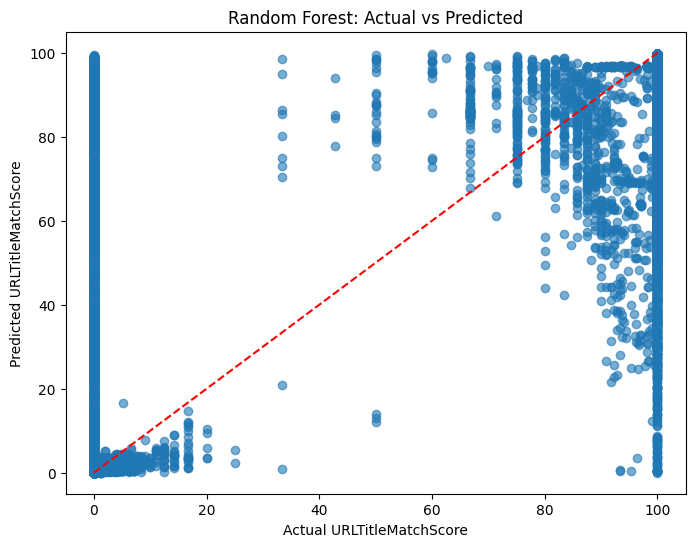

                       Feature    Importance
19  NoOfOtherSpecialCharsInURL  5.513293e-01
24                    HasTitle  2.071783e-01
3           URLSimilarityIndex  8.138150e-02
8                NoOfSubDomain  6.566564e-02
7                    TLDLength  2.442332e-02
5            TLDLegitimateProb  1.801818e-02
13            LetterRatioInURL  8.698806e-03
6                  URLCharProb  7.565629e-03
12            NoOfLettersInURL  6.698899e-03
4         CharContinuationRate  4.570862e-03
20       SpacialCharRatioInURL  4.244652e-03
1                 DomainLength  2.994530e-03
22                  LineOfCode  2.836803e-03
0                    URLLength  2.289966e-03
23           LargestLineLength  1.632256e-03
29            NoOfSelfRedirect  1.546815e-03
21                     IsHTTPS  1.294535e-03
15             DegitRatioInURL  1.108238e-03
47             NoOfExternalRef  9.258342e-04
45                 NoOfSelfRef  7.592698e-04
42                   NoOfImage  7.463313e-04
14        

In [19]:

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual URLTitleMatchScore')
plt.ylabel('Predicted URLTitleMatchScore')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

feature_names = X_train.columns

# Get importances
importances = rf.feature_importances_

# Make a DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp)

#### 2. K-Nearest Neighbors Regression

In [20]:

knn = KNeighborsRegressor(n_neighbors=5)

knn_scores = cross_validate(knn, X_train_scaled, y_train, cv=kf, scoring=scoring)

knn_results = {
    'MAE': -knn_scores['test_MAE'].mean(),
    'RMSE': -knn_scores['test_RMSE'].mean(),
    'R2': knn_scores['test_R2'].mean()
}

print(knn_results)

{'MAE': np.float64(10.702598559250383), 'RMSE': np.float64(24.733844222116495), 'R2': np.float64(0.7512812891093427)}


#### 3. Linear Regression

In [21]:
lr = LinearRegression()

lr_scores = cross_validate(lr, X_train_scaled, y_train, cv=kf, scoring=scoring)

lr_results = {
    'MAE': -lr_scores['test_MAE'].mean(),
    'RMSE': -lr_scores['test_RMSE'].mean(),
    'R2': lr_scores['test_R2'].mean()
}

print(lr_results)

{'MAE': np.float64(25.424160710233842), 'RMSE': np.float64(31.491947595661543), 'R2': np.float64(0.5968371844348282)}


### Results Summary and Model comparison

      Random Forest        KNN         LR
MAE        9.905771  10.702599  25.424161
RMSE      21.723205  24.733844  31.491948
R2         0.808147   0.751281   0.596837


<Axes: title={'center': 'Regression Model Comparison'}>

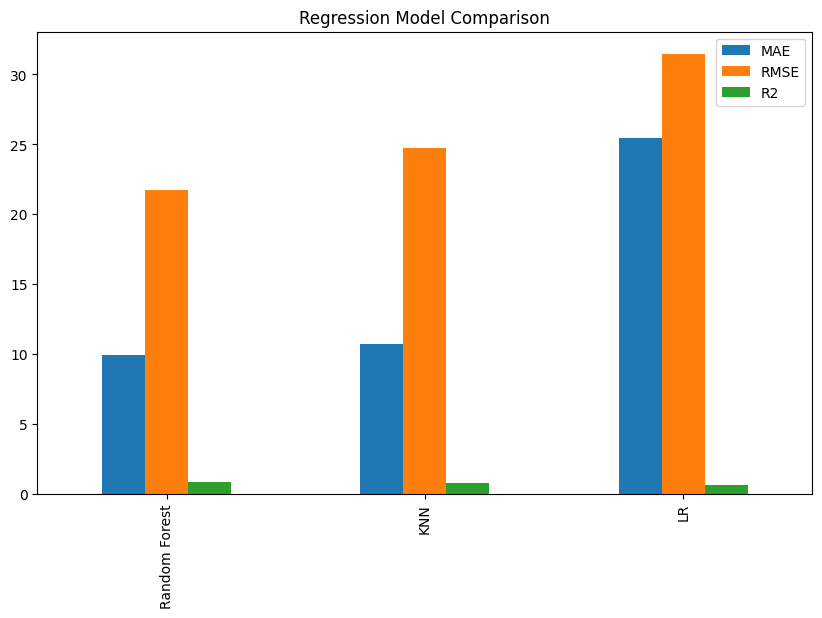

In [22]:
comparison = pd.DataFrame({
    'Random Forest': rf_results,
    'KNN': knn_results,
    'LR': lr_results
})

print(comparison)

comparison.T.plot(kind='bar', figsize=(10,6), title='Regression Model Comparison')

#### Each models advantages for Task 2: Regression.

- **Random Forest**: It captures complex and non-linear relationships and it sis robus to outliers. And the model requires minimal scailng.
- **KNN**: It's simpleand no assumption is needed.
- **SVR**: It can fit non-linear functions via Kernels and it is robust to outliers. Most of all, it works well in high-dimensional spaces when you have fewer samples than features.

#### Comparing Models with Statistical Significance

This section compares the models using their cross-validation scores to check if the differences in performance are statistically significant at the 95% confidence level.  
A paired t-test is used to compare the mean scores fold by fold for each pair of models.



In [23]:
from scipy.stats import ttest_rel

# Get fold-wise R2 scores
rf_r2_scores = rf_scores['test_R2']
knn_r2_scores = knn_scores['test_R2']
lr_r2_scores = lr_scores['test_R2']

# Define pairs to compare
pairs = [
    ('Random Forest', rf_r2_scores, 'KNN', knn_r2_scores),
    ('Random Forest', rf_r2_scores, 'Linear Regression', lr_r2_scores),
    ('KNN', knn_r2_scores, 'Linear Regression', lr_r2_scores)
]

# Run paired t-tests for each pair
for name1, scores1, name2, scores2 in pairs:
    t_stat, p_value = ttest_rel(scores1, scores2)
    print(f"Comparing {name1} vs {name2}:")
    print(f"  {name1} mean R2: {scores1.mean():.4f}")
    print(f"  {name2} mean R2: {scores2.mean():.4f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("  The difference is statistically significant at the 95% confidence level.\n")
    else:
        print("  The difference is not statistically significant at the 95% confidence level.\n")

Comparing Random Forest vs KNN:
  Random Forest mean R2: 0.8081
  KNN mean R2: 0.7513
  T-statistic: 54.9382
  P-value: 0.0000
  The difference is statistically significant at the 95% confidence level.

Comparing Random Forest vs Linear Regression:
  Random Forest mean R2: 0.8081
  Linear Regression mean R2: 0.5968
  T-statistic: 79.9401
  P-value: 0.0000
  The difference is statistically significant at the 95% confidence level.

Comparing KNN vs Linear Regression:
  KNN mean R2: 0.7513
  Linear Regression mean R2: 0.5968
  T-statistic: 45.7435
  P-value: 0.0000
  The difference is statistically significant at the 95% confidence level.



The paired t-tests show that the differences in R² scores between Random Forest, KNN, and Linear Regression are statistically significant at the 95% confidence level.

- Random Forest has the highest mean R², explaining the most variance in the target.
- KNN performs slightly worse than Random Forest but better than Linear Regression.
- Linear Regression has the lowest mean R², indicating that a simple linear approach does not capture the relationships as well as the more flexible models.

These results are expected because Random Forest can model complex, non-linear relationships and feature interactions, while Linear Regression is limited to a straight-line fit. KNN can handle non-linearity too but may be more sensitive to data structure and scaling.

Overall, Random Forest is the best-performing model for predicting `URLTitleMatchScore` based on this analysis.

#### Which attributes from the analysis are most important. 

Top feature: NoOfOtherSpecialCharsInURL (importance = 0.5513)


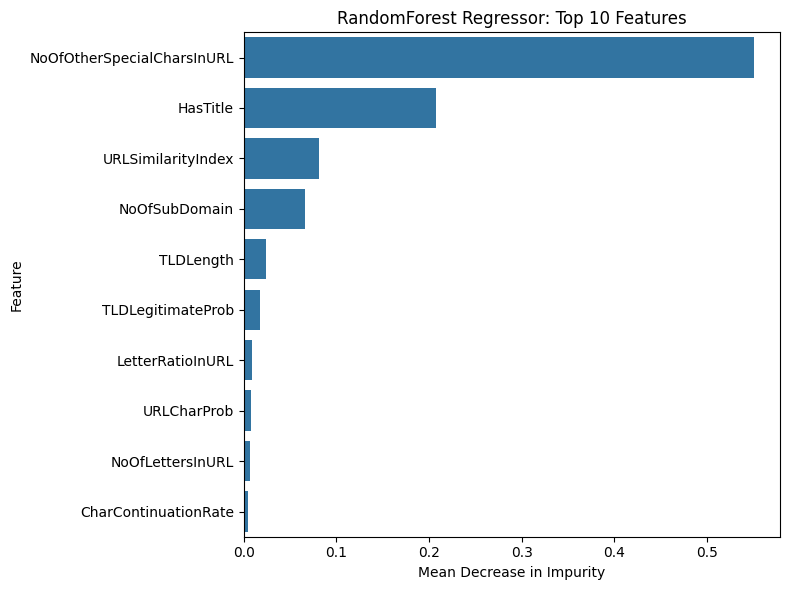

In [24]:
# 1) Print the top feature
top_feat = feat_imp.iloc[0]
print(f"Top feature: {top_feat['Feature']} (importance = {top_feat['Importance']:.4f})")



plt.figure(figsize=(8,6))
sns.barplot(
    data=feat_imp.head(10),
    x="Importance", y="Feature"
)
plt.title("RandomForest Regressor: Top 10 Features")
plt.xlabel("Mean Decrease in Impurity")
plt.tight_layout()
plt.show()


When **`NoOfOtherSpecialCharsInURL`** tops the importance list for predicting URL - Title match score, it tells you that variations in this feature explain more of the model's error reduction than any other signal. In practice, URLs that closely reflect a page's title tend to have "clean" human-readabble paths, whereas URLs littered with extra punctuation break the natural text-matching between slug and title. Legitimate pages often use descriptive URLs so they score high on URLTitleMatchScore and have few special characters. Conversely, URLs with lots of "other special chars" are more likely  auto-generated or obfuscated-common in tracking links or dynamically generated pages-so they systematically diverge from the page's visible title. Thus, the Random Forest leverages **`NoOfOtherSpecialCharsInURL`** as its leading splitter because it's the strongest single indicator of how "cleanly" a URL maps back to the human-readable title text.

### Model Analysis and Real-World Use(Deployment)

#### Which Features Matter Most

We used the Random Forest’s built-in feature importance scores to find out which attributes are most useful for predicting the `URLTitleMatchScore`.  
This method is appropriate because it shows how much each feature helps reduce prediction error when the model splits decision trees.

Based on the results, some of the most important features were:
- **NoOfOtherSpecialCharsInURL**: Extra special characters can make URLs look suspicious.
- **HasTitle**: Whether the page has a title that matches the URL.
- **URLSimilarityIndex**: Shows how similar the URL is to expected patterns.
- **NoOfSubDomain**: Extra subdomains can hide malicious intent or make a fake site look legitimate.

We dropped `DomainTitleMatchScore`, `Title`, and `label` from the predictors to avoid data leakage, since these could directly reveal or influence the target.

#### Why Do These Features Matter

These attributes help detect signs that a URL may be trying to look like a trusted site:
- Phishing sites often include extra special characters or subdomains to trick users.
- They mimic known titles and structures to seem legitimate.
- The similarity index captures how closely a suspicious URL matches a real one.

If we were doing classification instead of regression, these same features would likely still be important to distinguish phishing from legitimate websites.

#### Usefulness for Interested Parties

This kind of model could help security teams, email providers, or web browsers automatically detect and block suspicious URLs before users interact with them.  
It can reduce the workload for manual review, lower the risk of successful phishing attempts, and improve user safety by providing early warnings.


#### How to deploy the model. 
We can package the preprocessing and trained model into a Dockerized microservice exposing a REST API, backed by a load-balanced, auto-scaling cluster (e.g. Kubernetes) with a Redis cache for recent verdicts. Then integrate that API into email gateways, web proxies, and browser extensions so each URL lookup calls the service in real time with health checks and fallbacks for graceful degradation.


#### How often data should be collected and how often would the model need to be updated?
Gether both user and analyst feedback regarding overrides, late malicious flags and click-through behavior and external threat intelligence. Augment with page and network signals like HTML structure, login-form presence, and suspicious JavaScript patterns. The data can be updated regulary in incremental method which ill retrains on the latest labeled data. 



### Exceptional Work

#### K-Nearest Neighbors with Hyperparameter Tuning


In [25]:
# Train/validation/test split (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
knn_base = KNeighborsClassifier(weights='distance', algorithm='auto', n_jobs=-1)

grid_search = GridSearchCV(knn_base, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_k = grid_search.best_params_['n_neighbors']
print(f"Best K: {best_k}, CV Score: {grid_search.best_score_:.4f}")

knn_model = KNeighborsClassifier(n_neighbors=best_k, weights='distance', algorithm='auto', n_jobs=-1)
results['KNN'] = evaluate_model('KNN', knn_model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)

Train: 141,477 | Val: 47,159 | Test: 47,159
Best K: 3, CV Score: 0.9985
KNN:
  Val: Acc=0.9988, F1=0.9990, Prec=0.9982, Rec=0.9997, AUC=0.9993
  Test: Acc=0.9986, F1=0.9988, Prec=0.9981, Rec=0.9994, AUC=0.9992
  Additional: Specificity=0.9974, NPV=0.9993, Time=0.021s
